In [1]:
# the basic imports needed for our code
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.reset_default_graph()
# our layer function for our neural network
def add_layer(layer_input, layer_name, num_inputs, num_neurons, activation_function=None):
    random_val = 0.5
    with tf.name_scope('nn_layer'):
        with tf.name_scope('weights'):
            weights = tf.Variable(tf.random_normal([num_inputs, num_neurons]), name='W')
            tf.summary.histogram('layer' + layer_name + '/weights', weights)
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([1, num_neurons]) + random_val, name='b')
            tf.summary.histogram('layer' + layer_name + '/biases', biases)
        with tf.name_scope('layer_output'):
            layer_output = tf.add(tf.matmul(layer_input, weights), biases)
    if activation_function:
        return activation_function(layer_output)
    return layer_output

### Here we define the curve that we need to model using our NN

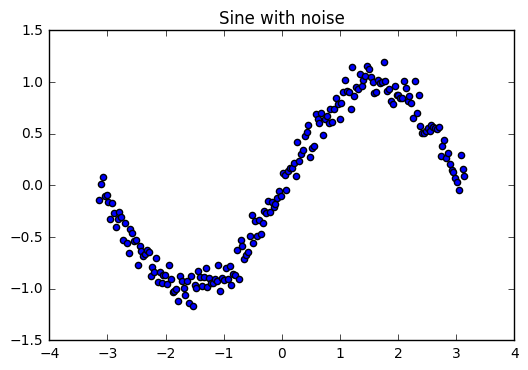

In [2]:
%matplotlib inline
num_rows = 200
X = np.linspace(-np.pi, np.pi, num_rows).reshape(num_rows, 1)
Y = np.sin(X)  + 2 * np.random.normal(0, 0.05, num_rows).reshape(num_rows, 1)
plt.scatter(X, Y)
plt.title('Sine with noise')
plt.show()

### We define the model of computation for our NN

In [7]:
# X and Y both have None -> rows which is an arbitrary number of rows
with tf.name_scope('input_node'):
    X_input = tf.placeholder(tf.float32, [None, 1], name='X_input')
    Y_input = tf.placeholder(tf.float32, [None, 1], name='Y_input')
activation_function = tf.nn.relu
learning_rate = 0.01
neurons_l1 = 10
neurons_l2 = 10
# input size of hidden_layer_1 is '1' because we assume that X is a single vector
hidden_layer_1 = add_layer(X_input, '1', 1, neurons_l1, activation_function)
hidden_layer_2 = add_layer(hidden_layer_1, '2', neurons_l1, neurons_l2, activation_function)
prediction = add_layer(hidden_layer_2, '3', neurons_l2, 1, None)
# can be replaced with better loss method
with tf.name_scope('LossFunc'):
    loss = tf.reduce_mean(tf.reduce_mean(tf.square(Y_input - prediction), 0))
    tf.summary.scalar('loss', loss)
with tf.name_scope('Trainer'):
    train_func = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

### Finally, we run our neural network, in an external window

In [8]:
%matplotlib
iterations = 2500
pause_interval = 0.1
with tf.Session() as session:
    mergedSummaries = tf.summary.merge_all()
    graphWriter = tf.summary.FileWriter('logs/', graph=tf.get_default_graph())
    init = tf.global_variables_initializer()
    session.run(init)
    fig = plt.figure()
    y_min, y_max = -1.5, 1.5
    axes0 = fig.add_subplot('111')
    axes0.scatter(X, Y)
    axes0.set_ylim([y_min, y_max])
    plt.ion()
    plt.show()
    
    for iteration in range(iterations):
        session.run(train_func, feed_dict={X_input: X, Y_input: Y})
        if iteration % 50 == 0:
            try:
                axes0.lines.remove(lines[0])
            except Exception:
                pass
            # our last layer is the one we need to make predictions
            Y_predicted = session.run(prediction, feed_dict={X_input: X})
            # adding results to our tensorboard summary
            summary = session.run(mergedSummaries, feed_dict={X_input: X,
                                                              Y_input: Y})
            graphWriter.add_summary(summary, iteration)
            plt.title('Iteration number : ' + str(iteration))
            lines = axes0.plot(X, Y_predicted, c='r', lw=5)
            plt.pause(pause_interval)
# loss which can be modeled using the scalar summary instead
#         if iteration % 100 == 0:
#             print(session.run(loss, feed_dict={X_input: X, Y_input: Y}))

Using matplotlib backend: Qt5Agg


InvalidArgumentError: You must feed a value for placeholder tensor 'input_node/X_input' with dtype float
	 [[Node: input_node/X_input = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: _recv_input_node_1/Y_input_0 = _Recv[client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=-5550184501753662286, tensor_name="input_node_1/Y_input:0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input_node/X_input', defined at:
  File "C:\Users\balac\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\balac\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\balac\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\balac\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Users\balac\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\balac\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\balac\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\balac\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\balac\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\balac\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\balac\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\balac\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\balac\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\balac\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\balac\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\balac\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\balac\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\balac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\balac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\balac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-1810f60b9217>", line 3, in <module>
    X_input = tf.placeholder(tf.float32, [None, 1], name='X_input')
  File "C:\Users\balac\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1502, in placeholder
    name=name)
  File "C:\Users\balac\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "C:\Users\balac\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Users\balac\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\balac\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_node/X_input' with dtype float
	 [[Node: input_node/X_input = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: _recv_input_node_1/Y_input_0 = _Recv[client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=-5550184501753662286, tensor_name="input_node_1/Y_input:0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
